#### Args

In [ ]:
## 1-(1) Argument Parser
import argparse, os
def get_args():
  parser = argparse.ArgumentParser(description = 'Ego-Vision Args')
  # Path
  parser.add_argument('--datapth', default = '/content/drive/MyDrive/Euron/assignment/data')
  parser.add_argument('--modelpth', default = '/content/drive/MyDrive/Euron/assignment/week01-EgoVision/ckpt')


  # Training Status
  parser.add_argument('--lr', type=float, default = 0.0002)
  parser.add_argument('--optim', choices = ['Adam', 'AdamW', 'SGD'], default = 'Adam')
  parser.add_argument('--scheduler', default = None)
  parser.add_argument('--loss', default = 'CrossEntropy')

  # Dataset
  parser.add_argument('--imgsize', type = int, default = 288)
  parser.add_argument('--epoch', default = 50)
  parser.add_argument('--batchsize', default = 16)


In [ ]:
## 1-(2) Load Library
import os, json, cv2, time, random, logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from pathlib import Path
from natsort import natsorted ## 이미지의 경로를 정렬하기 위해서
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from PIL import Image

# PyTorch
import torch.nn as nn
try:
  import timm
except:
  !pip install timm
  import timm
try:
  import torch_optimizer as optim
except:
  !pip install torch_optimizer
  import torch_optimizer as optim
  
import torch.utils.data as data
from torch.cuda.amp import autocast, grad_scaler
from torchvision import transforms

import warnings
warnings.filterwarnings('ignore')

     |████████████████████████████████| 431 kB 10.0 MB/s 
     |████████████████████████████████| 61 kB 538 kB/s 


#### Data EDA

In [ ]:
data_dir = '/content/drive/MyDrive/Euron/assignment/data'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')


In [58]:
def get_files(base_dir):
  base, json_dirs, img_dirs = [], [], []
  dirs = os.listdir(base_dir)
  temp = natsorted(list(map(lambda x: os.path.join(base_dir, x), dirs)))
  for t in temp:
    for root, dirs, files in os.walk(t):
      base.append(root)
      imgs = []
      for f in files:
        f_ = f.split('.')
        name, ext = f_[0], f_[1]
        if ext == 'json':
          json_dirs.append(f)
        else:
          imgs.append(f)
      img_dirs.append(imgs)
  df = pd.DataFrame({
      "root" : base,
      "json" : json_dirs,
      "img" : img_dirs
  })
  return df


In [59]:
train_df = get_files(train_dir)

In [60]:
train_df.head()

root    json  \
0  /content/drive/MyDrive/Euron/assignment/data/t...  0.json   
1  /content/drive/MyDrive/Euron/assignment/data/t...  1.json   
2  /content/drive/MyDrive/Euron/assignment/data/t...  2.json   
3  /content/drive/MyDrive/Euron/assignment/data/t...  3.json   
4  /content/drive/MyDrive/Euron/assignment/data/t...  4.json   

                                                 img  
0  [4.png, 1.png, 2.png, 5.png, 3.png, 0.png, 8.p...  
1  [2.png, 0.png, 3.png, 1.png, 6.png, 4.png, 5.png]  
2         [1.png, 2.png, 0.png, 4.png, 3.png, 5.png]  
3  [0.png, 5.png, 8.png, 6.png, 1.png, 7.png, 4.p...  
4  [8.png, 2.png, 4.png, 3.png, 1.png, 7.png, 5.p...

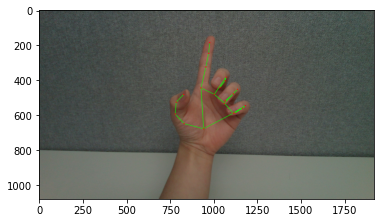

In [ ]:
img = os.path.join(train_df.iloc[0]['root'], '0.png')
image = np.array(Image.open(img).convert('RGB'))
plt.imshow(image)

In [ ]:
js = json.load(open(os.path.join(train_df.iloc[0]['root'],train_df.iloc[0]['json'] )))
keypoints = js['annotations']
keypoints[0]

{'data': [[943.4659194946289, 678.9908051490784, -0.07258573779836297],
  [831.5485382080078, 649.4491910934448, -154.91628170013428],
  [780.9441375732422, 594.6215343475342, -249.13023948669434],
  [786.9584655761719, 526.9233298301697, -319.0608215332031],
  [829.5905113220215, 482.93885707855225, -370.178861618042],
  [928.8368225097656, 445.8325123786926, -188.57235431671143],
  [956.165885925293, 325.0832176208496, -259.99417304992676],
  [972.0347213745117, 247.1524554491043, -332.45018005371094],
  [978.2339859008789, 186.77878975868225, -390.15440940856934],
  [1004.2246627807617, 481.9052195549011, -174.55859184265137],
  [1072.829360961914, 383.75391125679016, -316.6427993774414],
  [1066.5202331542969, 404.170618057251, -439.74520683288574],
  [1037.7899551391602, 442.18912839889526, -514.8169326782227],
  [1062.5819778442383, 532.8287494182587, -168.44341278076172],
  [1137.9583740234375, 453.31021070480347, -308.32886695861816],
  [1113.6016845703125, 479.85870480537415, 

In [ ]:
np.max(np.array(keypoints[0]['data']), axis = 0).astype(int)

array([1182,  678,    0])

In [ ]:
def crop_img(image, point, margin = 100):
  point = point['data']
  max_point = np.max(np.array(point), axis = 0).astype(int) + margin ## (x,y,z)각각에 대한 최댓값
  min_point = np.min(np.array(point), axis = 0).astype(int) - margin ## (x,y,z)각각에 대한 최솟값
  max_point, min_point = max_point[:-1], min_point[:-1] ## z부분은 이미지를 다룰 때에는 크게 필요한 부분이 아님

  max_x, max_y = max_point
  min_x, min_y = min_point
  max_y += margin

  ## 이미지의 크기를 넘어서는 경우에는 제외
  max_x = max_x if max_x < 1920 else 1920
  max_y = max_y if max_y < 1080 else 1080
  min_x = min_x if min_x > 0 else 0
  min_y = min_y if min_y > 0 else 0

  crop_image = image[min_y:max_y, min_x:max_x]
  return crop_image


In [ ]:
def visualize_img(df, idx, crop = False):
  """
  iloc 함수로 선택할 index의 번호를 인자로 받는다.
  해당 번호의 폴더에 있는 모든 이미지를 화면에 보여준다.
  """
  temp = df.iloc[idx]
  root, js, img = temp['root'], temp['json'], temp['img']
  num = len(img)
  img = natsorted(img)

  ## 이미지의 개수가 4개에서 11개까지 다양한 것으로 보아 나눠 주어서 계산해야 한다.
  rows, cols = 4,3
  axes = []
  fig = plt.figure(figsize = (20,20))
  i = 0
  js = json.load(open(os.path.join(root,js)))

  for _, (point, image_name) in enumerate(zip(js['annotations'], img)):
    image = np.array(Image.open(os.path.join(root,image_name)).convert('RGB'))
    if crop:
      image = crop_img(image, point,)
    axes.append(fig.add_subplot(rows,cols, i+1))
    i += 1
    axes[-1].set_title(f"{image_name}")
    plt.imshow(image)
  
  fig.tight_layout()
  plt.show()




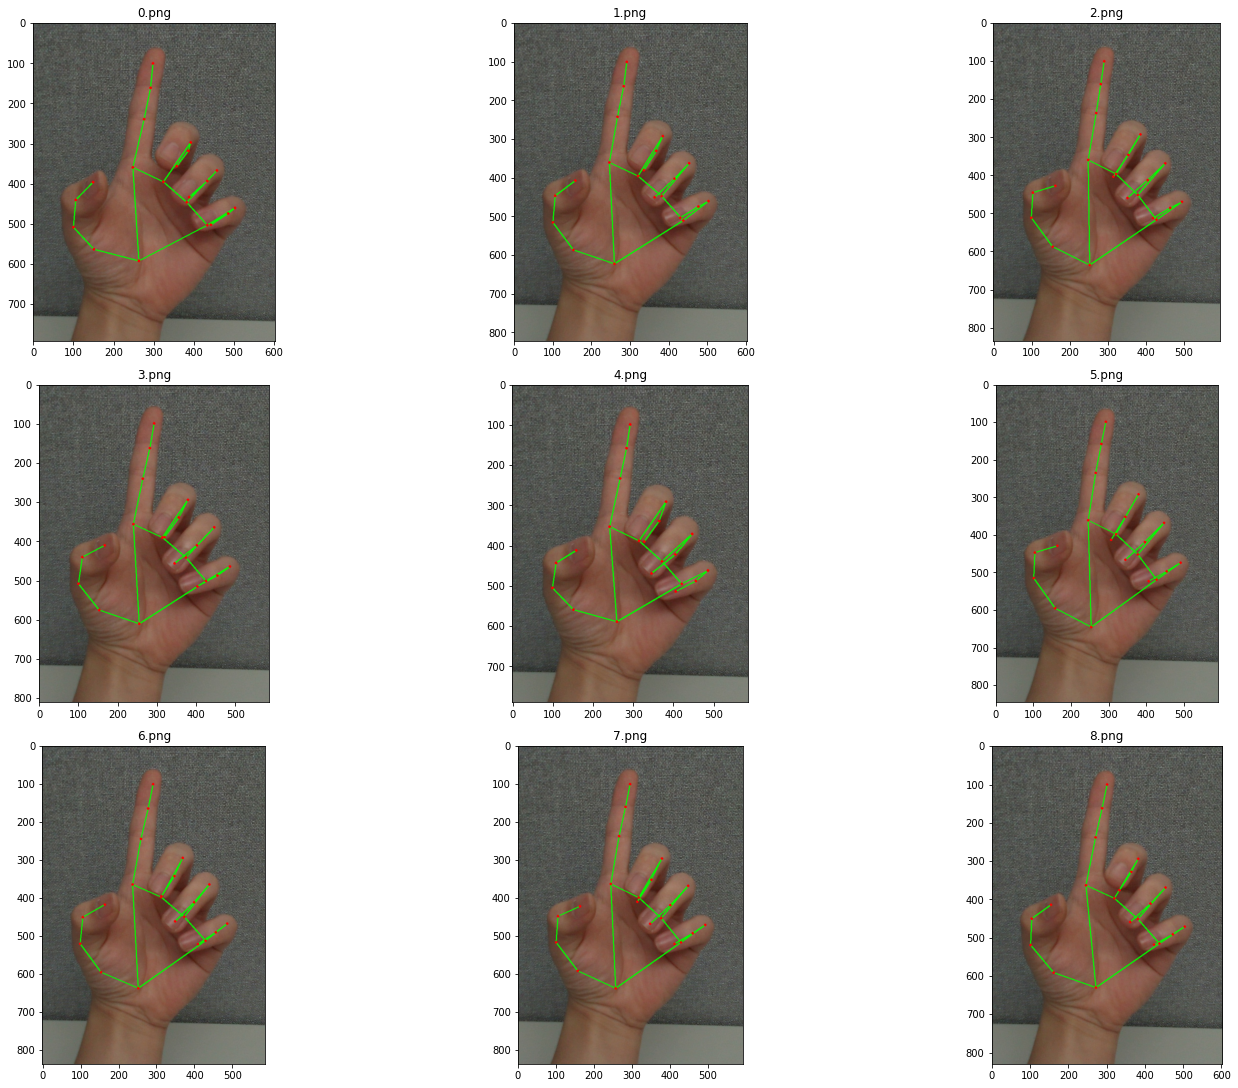

In [ ]:
visualize_img(train_df,0, True) ## 그렇게 큰 차이는 아니더라도 어느 정도의 미세한 움직임을 보인다는 사실을 확인 할 수 있다

In [ ]:
## hand_gesture_pose.csv
def get_details():
  csv_dir = '/content/drive/MyDrive/Euron/assignment/data/hand_gesture_pose.csv'
  df = pd.read_csv(csv_dir)
  return df

hand_pose = get_details()

In [ ]:
hand_pose.head() ## 세부적으로 왼손 / 오른손 / 의미 등 분류해 놓은 정보가 주어짐

pose_id pose_type pose_name gesture_type hand_type view_type
0        0    number      숫자 1      my_hand      left       1st
1        1    number      숫자 2      my_hand      left       1st
2        2    number      숫자 3      my_hand      left       1st
3        3    number      숫자 4      my_hand      left       1st
4        4    number      숫자 5      my_hand      left       1st

In [ ]:
## Dataframe for Training
train_folders = natsorted(glob(train_dir+ '/*'))

answers = []
for train_folder in train_folders:
  pth = os.path.join(train_dir, train_folder)
  idx = np.where(train_df.root == pth)[0][0]

  json_path = os.path.join(pth, train_df['json'][idx])
  js = json.load(open(json_path))
  cat = js.get('action')[0]
  cat_name = js.get('action')[1]
  image_list = train_df['img'][idx]
  for image_name in image_list:
    img_dir = os.path.join(pth, image_name)
    answers.append([img_dir, cat, cat_name])
answers = pd.DataFrame(answers, columns = ['train_path', 'answer', 'answer_name'])
answers.to_csv(os.path.join(data_dir,'train.csv'), index = False)


In [ ]:
answers = pd.read_csv(os.path.join(data_dir, 'train.csv'))

In [ ]:
answers['folder'] = list(map(lambda x: x.split('/')[-2], answers['train_path']))

In [ ]:
answers.head()

train_path  answer answer_name  \
0  /content/drive/MyDrive/Euron/assignment/data/t...       0        숫자 1   
1  /content/drive/MyDrive/Euron/assignment/data/t...       0        숫자 1   
2  /content/drive/MyDrive/Euron/assignment/data/t...       0        숫자 1   
3  /content/drive/MyDrive/Euron/assignment/data/t...       0        숫자 1   
4  /content/drive/MyDrive/Euron/assignment/data/t...       0        숫자 1   

  folder  
0      0  
1      0  
2      0  
3      0  
4      0

In [ ]:
max(list(set(answers['answer'])))

195

In [48]:
for i in range(196):
  temp = answers.loc[answers['answer'] == i]
  temp = list(set(temp['folder']))
  if (len(temp) == 1):
    print(i, temp)

47 ['163']
92 ['327']
131 ['444']
145 ['503']
188 ['622']


In [75]:
hand_pose.loc[hand_pose['pose_id'] == 92], hand_pose.loc[hand_pose['pose_id'] == 188], \
hand_pose.loc[hand_pose['pose_id'] == 145]
## X, 네모, 손하트의 3개의 서로 다른  손동작을 의미한다.

(    pose_id pose_type pose_name gesture_type hand_type view_type
 77       92   meaning         X      my_hand      both       1st,
      pose_id pose_type pose_name gesture_type hand_type view_type
 149      188   meaning        네모    your_hand      both       3rd,
      pose_id pose_type pose_name gesture_type hand_type view_type
 120      145   meaning       손하트    your_hand     right       3rd)

In [62]:
hand_pose.loc[hand_pose['pose_id'] == 47], hand_pose.loc[hand_pose['pose_id'] == 22]
## 손가락 오므리기 오 / 왼

(    pose_id pose_type pose_name gesture_type hand_type view_type
 39       47   meaning  손가락 오므리기      my_hand     right       1st,
     pose_id pose_type pose_name gesture_type hand_type view_type
 20       22   meaning  손가락 오므리기      my_hand      left       1st)

In [56]:
hand_pose.loc[hand_pose['pose_id'] == 131], hand_pose.loc[hand_pose['pose_id'] == 156]
## 검지, 중지 교차 오 / 왼

(     pose_id pose_type pose_name gesture_type hand_type view_type
 106      131   meaning  검지,중지 교차    your_hand      left       3rd,
      pose_id pose_type pose_name gesture_type hand_type view_type
 130      156   meaning  검지,중지 교차    your_hand     right       3rd)

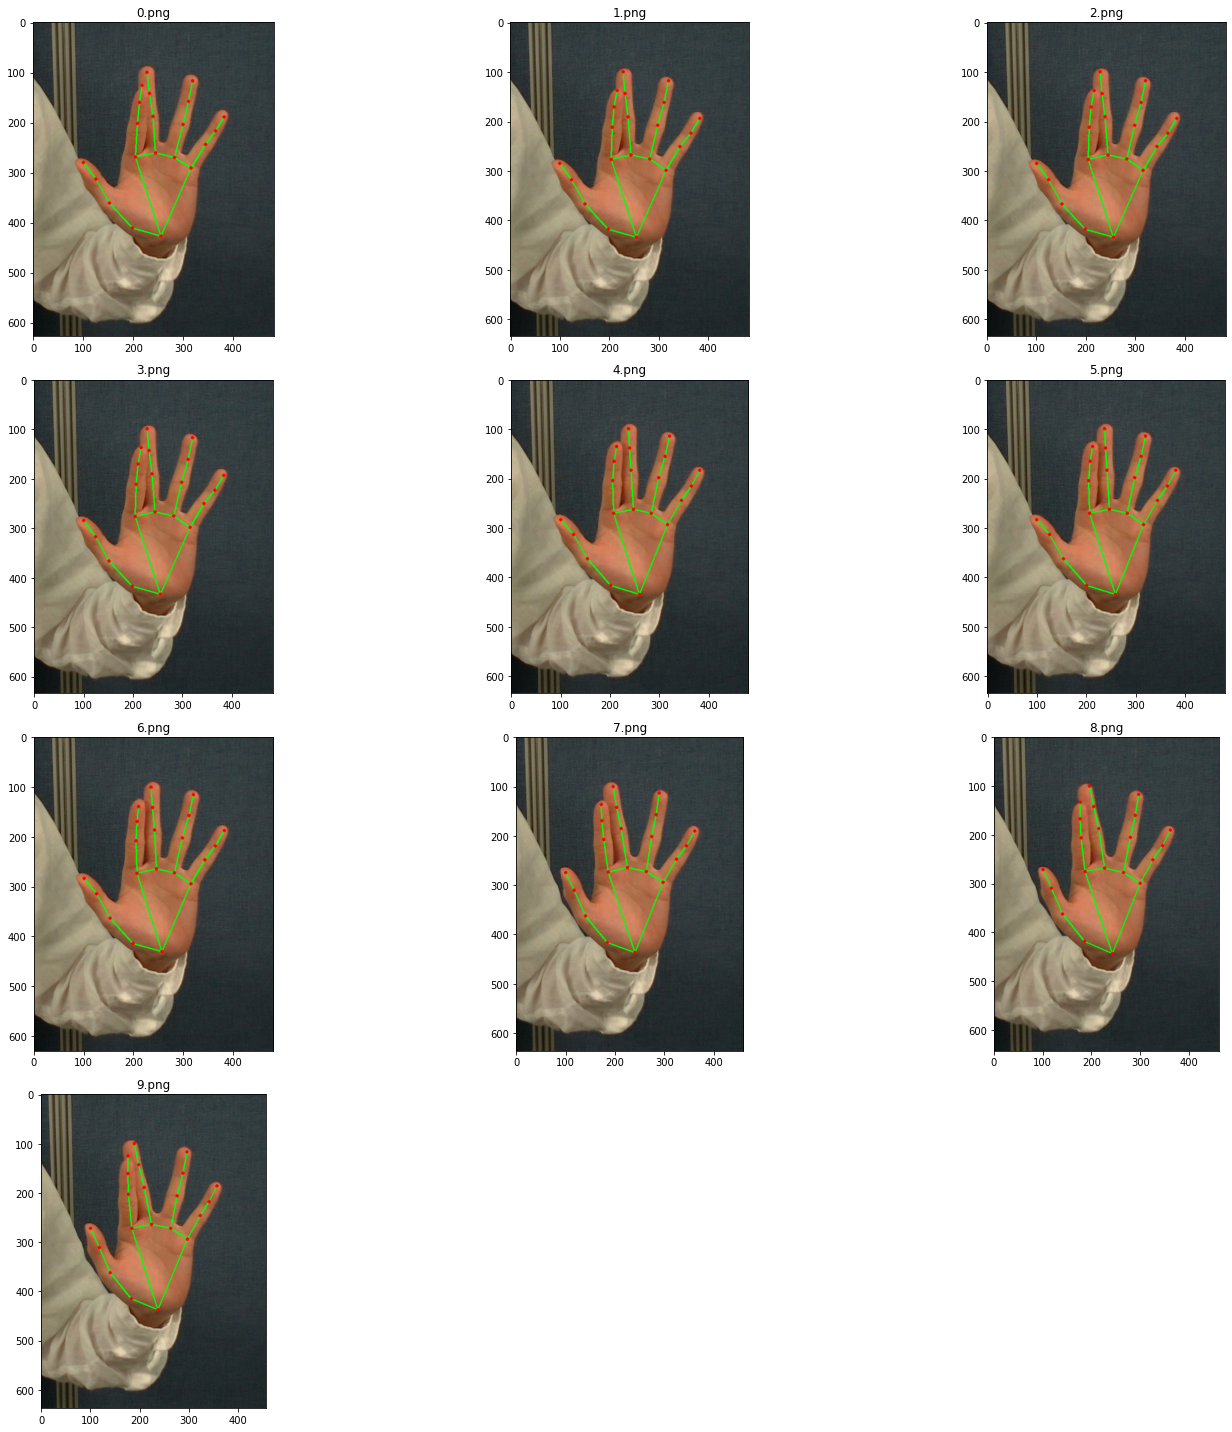

In [61]:
visualize_img(train_df, 444, True) ## 검지 중지를 교차하는 상황

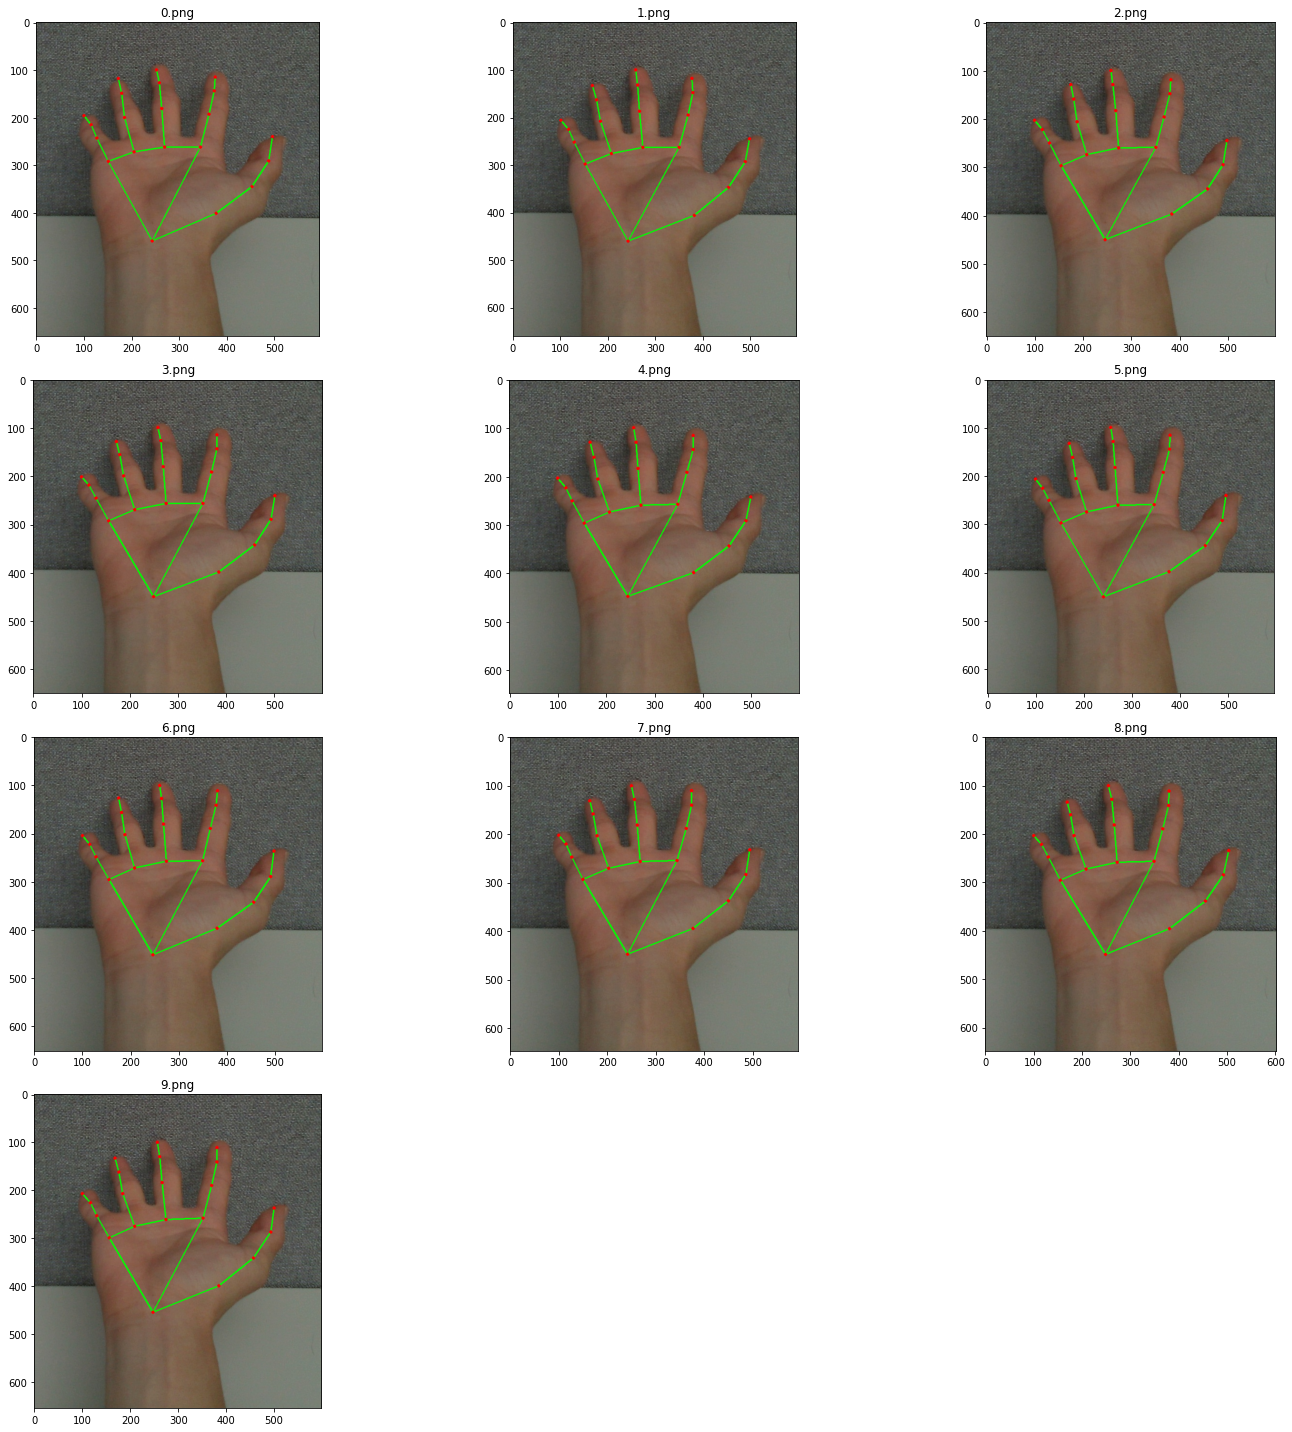

In [49]:
visualize_img(train_df, 163, True)

#### DataLoader

In [ ]:
answer_stat = pd.value_counts(answers['answer_name'].values, sort = True)
answer_stat.values

array([396, 276, 263, 253, 235, 220, 213, 212, 207, 204, 195, 194, 177,
       177, 172, 134, 124, 110, 110, 107, 100,  99,  98,  96,  95,  95,
        95,  90,  88,  84,  83,  82,  71,  67,  61,  61,  59,  58,  56,
        48,  48,  47,  47,  47,  38,  37,  30,  29])

In [ ]:
## 특정 class의 분포가 너무 적기 때문에 클래스의 분포가 1개만 있는 경우에 Augmentation 적용
## 이미지를 생성해서 dataframe을 재정의함 -> 조금의 성능의 향상이 있다고 함

def set_seed(seed = 42):
  os.environ['PYTHONHASHSEED'] = str(seed)
  random.seed(seed)
  np.random.seed(seed)

set_seed()

In [63]:
df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
df_train = df_train.merge(hand_pose[['pose_id', 'gesture_type', 'hand_type']],
                          how = 'left', left_on = 'answer', right_on = 'pose_id')


In [64]:
df_train.head()

train_path  answer answer_name  \
0  /content/drive/MyDrive/Euron/assignment/data/t...       0        숫자 1   
1  /content/drive/MyDrive/Euron/assignment/data/t...       0        숫자 1   
2  /content/drive/MyDrive/Euron/assignment/data/t...       0        숫자 1   
3  /content/drive/MyDrive/Euron/assignment/data/t...       0        숫자 1   
4  /content/drive/MyDrive/Euron/assignment/data/t...       0        숫자 1   

   pose_id gesture_type hand_type  
0        0      my_hand      left  
1        0      my_hand      left  
2        0      my_hand      left  
3        0      my_hand      left  
4        0      my_hand      left

In [68]:
train_dir

'/content/drive/MyDrive/Euron/assignment/data/train'

In [72]:
import os

for i in range(649, 649 + 5):
  if not os.path.exists(os.path.join(train_dir, str(i))):
    os.makedirs(os.path.join(train_dir, str(i)))

folders = ['649', '650']
org, flip = [131,47], [156,22]

## 하나의 폴더에만 속해 있는 label에 대해서 데이터 증강 기법을 생각해 봄
## 완전히 반대 손인 경우에 대해서 flip해 주면 데이터를 조금이나마 늘릴 수 있음

for osl, fl, folder in tqdm(zip(org, flip, folders)):
  idx = 0
  one_sample = df_train[df_train['answer'] == osl].reset_index(drop = True)
  temp = df_train[df_train['answer'] == fl].reset_index(drop = True)
  train_folders = natsorted(temp['train_path'].apply(lambda x: x[:-6]).unique())
  for train_folder in train_folders:
    json_path = glob(train_folder + '/*.json')[0]
    js = json.load(open(json_path))
    kpts = js['annotations']
    img_list = natsorted(glob(train_folder + '*.png'))
    
    for _, (point, image_name) in enumerate(zip(kpts, img_list)):
      image = np.array(Image.open(os.path.join(train_dir, train_folder, image_name)).convert('RGB'))
      croped_image = crop_img(image, point, 50)
      flip_img = cv2.flip(croped_image, 1)
      save_path = os.path.join(train_dir, folder, f"{idx}.png")
      idx += 1
      cv2.imwrite(save_path, flip_img)
      df_train.loc[len(df_train)] = [save_path] + one_sample.iloc[0][1:].values.tolist()



2it [00:00, 17.63it/s]


In [76]:
def rotation(image, angle):
  angle = int(random.uniform(-angle, angle))
  h,w = image.shape[:2]

  ## 회전 행렬을 구해 줌
  M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
  
  ## 아핀 변환을 진행 해 준다. Scale과 평형성으로 모두 유지하면서 변환을 해 준다.
  image = cv2.warpAffine(image, M, (w,h))
  return image

In [83]:
labels, folders = [92, 188, 145], ['651', '652', '653']
for label, folder in tqdm(zip(labels, folders)):
  idx = 0
  temp = df_train[df_train['answer'] == label].reset_index(drop = True)
  train_folders = natsorted(temp['train_path'].apply(lambda x:x[:-6]).unique())
  for fol in train_folders:
    json_pth = glob(fol + '/*.json')[-1]
    js = json.load(open(json_pth))
    kpts = js['annotations']
    image_lists = natsorted(glob(fol + '/*.png'))
  
    for _, (point, image_name) in enumerate(zip(kpts, image_lists)):
      image = np.array(Image.open(os.path.join(train_dir, fol, image_name)).convert('RGB'))
      croped_image = crop_img(image, point, 50)
      aug_img = rotation(croped_image, 30)
      save_path = os.path.join(train_dir, fol, f'{idx}.png')
      idx += 1
      cv2.imwrite(save_path, aug_img)
      df_train.loc[len(df_train)] = [save_path] + temp.iloc[0][1:].values.tolist()

df_train.to_csv(os.path.join(data_dir, 'add_train.csv'), index = False)
    

3it [00:14,  4.97s/it]


In [86]:
df_train = pd.read_csv(os.path.join(data_dir, 'add_train.csv'))
df_train[-10:]

train_path  answer answer_name  \
5906  /content/drive/MyDrive/Euron/assignment/data/t...     145         손하트   
5907  /content/drive/MyDrive/Euron/assignment/data/t...     145         손하트   
5908  /content/drive/MyDrive/Euron/assignment/data/t...     145         손하트   
5909  /content/drive/MyDrive/Euron/assignment/data/t...     145         손하트   
5910  /content/drive/MyDrive/Euron/assignment/data/t...     145         손하트   
5911  /content/drive/MyDrive/Euron/assignment/data/t...     145         손하트   
5912  /content/drive/MyDrive/Euron/assignment/data/t...     145         손하트   
5913  /content/drive/MyDrive/Euron/assignment/data/t...     145         손하트   
5914  /content/drive/MyDrive/Euron/assignment/data/t...     145         손하트   
5915  /content/drive/MyDrive/Euron/assignment/data/t...     145         손하트   

      pose_id gesture_type hand_type  
5906      145    your_hand     right  
5907      145    your_hand     right  
5908      145    your_hand     right  
5909      145    your_hand     right  
5910      145    your_hand     right  
5911      145    your_hand     right  
5912      145    your_hand     right  
5913      145    your_hand     right  
5914      145    your_hand     right  
5915      145    your_hand     right

In [87]:
hand_pose = get_details()
hand_pose.head()

pose_id pose_type pose_name gesture_type hand_type view_type
0        0    number      숫자 1      my_hand      left       1st
1        1    number      숫자 2      my_hand      left       1st
2        2    number      숫자 3      my_hand      left       1st
3        3    number      숫자 4      my_hand      left       1st
4        4    number      숫자 5      my_hand      left       1st

In [91]:
list(set(hand_pose['pose_type']))
## meaning (언어적 의미) / number (숫자 표현) 
## 대분류로 나누자면 크게 이렇게 되고 나머지의 경우에는

['meaning', 'number']

In [89]:
pn, gt, ht, vt = hand_pose['pose_name'], hand_pose['gesture_type'], hand_pose['hand_type'], hand_pose['view_type']
labels = []
for a, b, c, d in zip(pn, gt, ht, vt):
  labels.append(f"{a}_{b}_{c}_{d}")
labels = list(set(labels))

In [90]:
labels

['숫자7_your_hand_right_3rd',
 '약지,소지 가위_your_hand_right_3rd',
 '손바닥_my_hand_left_1st',
 '손가락 오므리기_your_hand_both_3rd',
 '동그라미_your_hand_both_3rd',
 '경고(주먹 내밀기)_your_hand_left_3rd',
 '엄지,중지 붙이기_my_hand_left_1st',
 '숫자 0_my_hand_left_1st',
 '최고_my_hand_both_1st',
 '최고_your_hand_left_3rd',
 '동그라미_your_hand_right_3rd',
 '엄지,약지 붙이기_your_hand_right_3rd',
 '주먹쥐기_your_hand_both_3rd',
 '경고(주먹 내밀기)_your_hand_right_3rd',
 '세모_my_hand_both_1st',
 '전화모양_my_hand_both_1st',
 '부정(엄지손 아래로)_my_hand_both_1st',
 '최고_my_hand_left_1st',
 '네모_your_hand_both_3rd',
 '손가락 오므리기_my_hand_right_1st',
 '숫자7_your_hand_left_3rd',
 '총_your_hand_left_3rd',
 '동그라미_your_hand_left_3rd',
 '엄지,약지 붙이기_my_hand_right_1st',
 '약속_my_hand_left_1st',
 '손 안경_my_hand_right_1st',
 '부정(엄지손 아래로)_my_hand_right_1st',
 '숫자6_your_hand_right_3rd',
 '손가락 오므리기_my_hand_both_1st',
 '동그라미_my_hand_both_1st',
 'OK_my_hand_left_1st',
 '숫자 5_my_hand_left_1st',
 '엄지,소지 붙이기_my_hand_right_1st',
 '총_my_hand_right_1st',
 'X_your_hand_both_3rd',
 '전화모양_your

In [ ]:
## trainset의 475, 543 폴더의 경우에는 의도하지 않은 나머지 부분에 대해서도 keypoint가 잡히게 된다.
def remove_keypoints(idx, points):
  lst = []
  for x, y, z in points:
    cond1 = x < 250 and y > 800
    cond2 = x > 1400 and y < 400
    if not (cond1 or cond2):
      lst.append([x,y,z])
  return lst


#### Model


In [ ]:
class PoseNet(nn.Module):
  def __init__(self, args):
    super().__init__()
    self.encoder = timm.create_model(
        args.encoder_name, pretrained = True, 
        drop_path_rate = args.drop_path_rate
    )
    num_head = self.encoder.fc.in_features
    self.encoder.head.fc = nn.Linear(num_head, 157)
  
  def forward(self, x):
    return self.encoder(x)

#### Trainer

In [ ]:
# Warmup Learning rate scheduler
from torch.optim.lr_scheduler import _LRScheduler
class WarmUpLR(_LRScheduler):
    """warmup_training learning rate scheduler
    Args:
        optimizer: optimzier(e.g. SGD)
        total_iters: totoal_iters of warmup phase
    """
    def __init__(self, optimizer, total_iters, last_epoch=-1):
        
        self.total_iters = total_iters
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        """we will use the first m batches, and set the learning
        rate to base_lr * m / total_iters
        """
        return [base_lr * self.last_epoch / (self.total_iters + 1e-8) for base_lr in self.base_lrs]

# Logging
def get_root_logger(logger_name='basicsr',
                    log_level=logging.INFO,
                    log_file=None):

    logger = logging.getLogger(logger_name)
    # if the logger has been initialized, just return it
    if logger.hasHandlers():
        return logger

    format_str = '%(asctime)s %(levelname)s: %(message)s'
    logging.basicConfig(format=format_str, level=log_level)

    if log_file is not None:
        file_handler = logging.FileHandler(log_file, 'w')
        file_handler.setFormatter(logging.Formatter(format_str))
        file_handler.setLevel(log_level)
        logger.addHandler(file_handler)

    return logger

class AvgMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.losses = []

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        self.losses.append(val)


In [ ]:
class Trainer():
    def __init__(self, args, save_path):
        '''
        args: arguments
        save_path: Model 가중치 저장 경로
        '''
        super(Trainer, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Logging
        log_file = os.path.join(save_path, 'log.log')
        self.logger = get_root_logger(logger_name='IR', log_level=logging.INFO, log_file=log_file)
        self.logger.info(args)
        self.logger.info(args.tag)

        # Train, Valid Set load
        ############################################################################
        # df_train = pd.read_csv(opj(args.data_path, 'df_train.csv'))
        df_train = pd.read_csv(opj(args.data_path, 'df_train_add.csv'))
        df_info = pd.read_csv(opj(args.data_path, 'hand_gesture_pose.csv'))

        df_train = df_train.merge(df_info[['pose_id', 'gesture_type', 'hand_type']], \
                                how='left', left_on='answer', right_on='pose_id')

        # 폴더별(Group)로 각 번호 부여
        df_train['groups'] = df_train['train_path'].apply(lambda x:x.split('/')[3])
        df_train.loc[:,:] = natsorted(df_train.values)
        # 노이즈 이미지 제거: 596번은 주먹쥐기 이미지인데 갑자기 손바닥을 펴는 노이즈 이미지가 5장있음 + 0번 폴더에 9번 이미지 역시 잘못된 클래스
        drop_idx = df_train[df_train['groups'].isin(['596'])].index.tolist()[3:8] + [9]  
        df_train = df_train.drop(drop_idx).reset_index(drop=True)  
        le = LabelEncoder()
        df_train['answer'] = le.fit_transform(df_train['answer'])
        
        # Split Fold
        # kf = StratifiedGroupKFold(n_splits=args.Kfold)
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=args.seed)
        for fold, (train_idx, val_idx) in enumerate(kf.split(df_train, y=df_train['answer'])):
            df_train.loc[val_idx, 'fold'] = fold
        df_val = df_train[df_train['fold'] == args.fold].reset_index(drop=True)
        df_train = df_train[df_train['fold'] != args.fold].reset_index(drop=True)
        
        # Augmentation
        self.train_transform = get_train_augmentation(img_size=args.img_size, ver=args.aug_ver)
        self.test_transform = get_train_augmentation(img_size=args.img_size, ver=1)
        
        ######################################################################
        # Flip Augmentation을 위한 Mapping dataframe
        df_info = pd.read_csv('../data/hand_gesture_pose.csv')
        df_info = df_info[df_info['hand_type'] != 'both']
        # drop idx, 동일한 약속, gesture_type, hand_type인데 다른 클래스인 경우 존재 -> 약속 1과 2로 이름을 나누어줌.
        df_info.loc[[105, 128], 'pose_name'] = '약속 1'  # idx: (105, 128)
        df_info.loc[[101, 124], 'pose_name'] = '약속 2'  # idx: (101, 124)

        # drop 41 idx, 동일한 약속, my hand, right class가 49와 54로 두 개있어 Mapping df만들 때 문제가 발생하여 미리 49번 클래스 처리
        df_info = df_info.drop(41)

        # Make a mapping dataframe
        df_info = df_info.groupby(['pose_name', 'view_type', 'gesture_type', 'hand_type']).sum().unstack().reset_index().dropna(axis=0)
        df_info['left'] = df_info.pose_id.left.apply(int)
        df_info['right'] = df_info.pose_id.right.apply(int)
        df_flip_info = df_info.drop('pose_id', axis=1).droplevel('hand_type', axis=1).reset_index(drop=True)
        print('Mapping dataframe Length', df_flip_info.shape)
        ######################################################################
        
        # TrainLoader
        self.train_loader = get_loader(df_train, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers, transform=self.train_transform, 
                                       df_flip_info=df_flip_info, flipaug_ratio=args.flipaug_ratio, label_encoder=le, margin=args.margin, random_margin=args.random_margin)
        self.val_loader = get_loader(df_val, batch_size=args.batch_size, shuffle=False,
                                       num_workers=args.num_workers, transform=self.test_transform)

        # Network
        self.model = Pose_Network(args).to(self.device)
        macs, params = get_model_complexity_info(self.model, (3, args.img_size, args.img_size), as_strings=True,
                                                 print_per_layer_stat=False, verbose=False)
        self.logger.info('{:<30}  {:<8}'.format('Computational complexity: ', macs))
        self.logger.info('{:<30}  {:<8}'.format('Number of parameters: ', params))

        # Loss
        self.criterion = nn.CrossEntropyLoss()
        
        # Optimizer & Scheduler
        self.optimizer = optim.Lamb(self.model.parameters(), lr=args.initial_lr, weight_decay=args.weight_decay)
        
        iter_per_epoch = len(self.train_loader)
        self.warmup_scheduler = WarmUpLR(self.optimizer, iter_per_epoch * args.warm_epoch)

        if args.scheduler == 'cos':
            tmax = args.tmax # half-cycle 
            self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max = tmax, eta_min=args.min_lr, verbose=True)
        elif args.scheduler == 'cycle':
            self.scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, max_lr=args.max_lr, steps_per_epoch=iter_per_epoch, epochs=args.epochs)

        
        if args.multi_gpu:
            self.model = nn.DataParallel(self.model).to(self.device)

        # Train / Validate
        best_loss = np.inf
        best_acc = 0
        best_epoch = 0
        early_stopping = 0
        start = time.time()
        for epoch in range(1, args.epochs+1):
            self.epoch = epoch

            if args.scheduler == 'cos':
                if epoch > args.warm_epoch:
                    self.scheduler.step()

            # Training
            train_loss, train_acc = self.training(args)

            # Model weight in Multi_GPU or Single GPU
            state_dict= self.model.module.state_dict() if args.multi_gpu else self.model.state_dict()

            # Validation
            val_loss, val_acc = self.validate()

            # Save models
            if val_loss < best_loss:
                early_stopping = 0
                best_epoch = epoch
                best_loss = val_loss
                best_acc = val_acc

                torch.save({'epoch':epoch,
                            'state_dict':state_dict,
                            'optimizer': self.optimizer.state_dict(),
                            'scheduler': self.scheduler.state_dict(),
                    }, os.path.join(save_path, 'best_model.pth'))
                self.logger.info(f'-----------------SAVE:{best_epoch}epoch----------------')
            else:
                early_stopping += 1

            # Early Stopping
            if early_stopping == args.patience:
                break

        self.logger.info(f'\nBest Val Epoch:{best_epoch} | Val Loss:{best_loss:.4f} | Val Acc:{best_acc:.4f}')
        end = time.time()
        self.logger.info(f'Total Process time:{(end - start) / 60:.3f}Minute')


    # Training
    def training(self, args):
        self.model.train()
        train_loss = AvgMeter()
        train_acc = 0

        scaler = grad_scaler.GradScaler()
        for i, (images, targets) in enumerate(tqdm(self.train_loader)):
            images = torch.tensor(images, device=self.device, dtype=torch.float32)
            targets = torch.tensor(targets, device=self.device, dtype=torch.long)
            
            if self.epoch <= args.warm_epoch:
                self.warmup_scheduler.step()

            self.model.zero_grad(set_to_none=True)
            if args.amp:
                with autocast():
                    preds = self.model(images)
                    loss = self.criterion(preds, targets)
                scaler.scale(loss).backward()

                # Gradient Clipping
                if args.clipping is not None:
                    scaler.unscale_(self.optimizer)
                    nn.utils.clip_grad_norm_(self.model.parameters(), args.clipping)

                scaler.step(self.optimizer)
                scaler.update()

            else:
                preds = self.model(images)
                loss = self.criterion(preds, targets)
                loss.backward()
                nn.utils.clip_grad_norm_(self.model.parameters(), args.clipping)
                self.optimizer.step()

            if args.scheduler == 'cycle':
                if self.epoch > args.warm_epoch:
                    self.scheduler.step()

            # Metric
            train_acc += (preds.argmax(dim=1) == targets).sum().item()
            # log
            train_loss.update(loss.item(), n=images.size(0))
            
        train_acc /= len(self.train_loader.dataset)

        self.logger.info(f'Epoch:[{self.epoch:03d}/{args.epochs:03d}]')
        self.logger.info(f'Train Loss:{train_loss.avg:.3f} | Acc:{train_acc:.4f}')
        return train_loss.avg, train_acc
            
    # Validation or Dev
    def validate(self):
        self.model.eval()
        with torch.no_grad():
            val_loss = AvgMeter()
            val_acc = 0

            for _, (images, targets) in enumerate(self.val_loader):
                images = torch.tensor(images, device=self.device, dtype=torch.float32)
                targets = torch.tensor(targets, device=self.device, dtype=torch.long)

                preds = self.model(images)
                loss = self.criterion(preds, targets)

                # Metric
                val_acc += (preds.argmax(dim=1) == targets).sum().item()
                # log
                val_loss.update(loss.item(), n=images.size(0))
            val_acc /= len(self.val_loader.dataset)

            self.logger.info(f'Valid Loss:{val_loss.avg:.3f} | Acc:{val_acc:.4f}')
        return val_loss.avg, val_acc
